## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [1]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [2]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [3]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


In [4]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

⚠️  Trí nhớ trống, không có gì để xây dựng vector store.

## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [5]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [6]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [7]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [8]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH, PERSONA & CÁC CẤU TRÚC DỮ LIỆU (NÂNG CẤP V9.0)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- HÀM TIỆN ÍCH & PERSONA (giữ nguyên) ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === NÂNG CẤP V9.0: PYDANTIC MODELS MỚI CHO TƯ DUY SÂU ===

class DifferentiatedInstructionModel(BaseModel):
    """Gợi ý cụ thể cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str = Field(description="Một gợi ý hoạt động, câu hỏi, hoặc sự hỗ trợ cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Một câu hỏi mở rộng, một thử thách, hoặc một hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập. Ví dụ: 'Thảo luận nhóm về ứng dụng của Tích phân'")
    description: str = Field(description="Mô tả chi tiết các bước HỌC SINH cần làm.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở cụ thể cho học sinh.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá. Ví dụ: 'Thử thách cuối bài'")
    question: str = Field(description="Nội dung câu hỏi hoặc đề bài toán cụ thể.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này, ví dụ một câu hỏi phụ khó hơn.")

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    """Mở rộng StudentPersona để bao gồm cả chiến lược phân hóa tổng thể."""
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

# --- Các model khác giữ nguyên ---
class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")
    suggested_duration: Optional[int] = Field(default=None, description="Nếu có lỗi về thời gian, hãy đề xuất một thời lượng hợp lý hơn (tính bằng SỐ PHÚT).")

class Domain(BaseModel):
    domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")

class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]

class BlueprintStage(BaseModel):
    stage_name: str = Field(description="Tên của giai đoạn.")
    stage_objective: str = Field(description="Mô tả mục tiêu của giai đoạn này.")
    stage_direction: str = Field(description="Định hướng chung về hoạt động trong giai đoạn này.")

class PedagogicalBlueprint(BaseModel):
    blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.


In [9]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [10]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [11]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [12]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC VÀ CÁC AGENT CHUYÊN MÔN (PHIÊN BẢN SỬA LỖI VÒNG LẶP)
# ==============================================================================

# ------------------------------------------------------------------------------
# HÀM plan_delegator_agent ĐÃ SỬA LỖI LOGIC VÀ PROMPT
# ------------------------------------------------------------------------------
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    topic = state.get('analyzed_objective', {}).get('topic', 'chủ đề đã cho')
    reflection_notes = state.get('reflection_notes') # Lấy phản hồi từ lần trước (nếu có)

    # Xây dựng prompt động
    replan_prompt_part = ""
    if reflection_notes:
        print_warning(f"Nhận được yêu cầu làm lại kế hoạch từ Critic: {reflection_notes}")
        # --- NÂNG CẤP TRIỆT ĐỂ ---
        replan_prompt_part = f"""
        **MỆNH LỆNH TỪ VÒNG LẶP TRƯỚC (BẮT BUỘC TUÂN THỦ TUYỆT ĐỐI):**
        "{reflection_notes}"

        **HƯỚNG DẪN THỰC HIỆN MỆNH LỆNH:**
        1.  **ĐỌC KỸ PHẢN HỒI:** Phản hồi trên chỉ ra rằng kế hoạch trước đó có lỗi về thời gian cho MỘT nhiệm vụ cụ thể.
        2.  **TÌM GỢI Ý:** Tìm chuỗi `SUGGESTED_DURATION: [số phút]` trong phản hồi.
        3.  **ÁP DỤNG MỆNH LỆNH:** Khi tạo danh sách nhiệm vụ mới, bạn BẮT BUỘC phải tạo ra một nhiệm vụ tương ứng với nhiệm vụ bị lỗi và gán cho nó thời lượng **CHÍNH XÁC** bằng `[số phút]` đó.
        4.  **PHÂN BỔ LẠI:** Sau khi đã ấn định thời gian cho nhiệm vụ lỗi, hãy phân bổ lại thời gian còn lại cho các nhiệm vụ khác một cách hợp lý.
        """

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một **Trợ lý Sư phạm**, chuyên viên thực thi và điều chỉnh kế hoạch một cách chính xác.
    **NHIỆM VỤ:** Dựa vào **Bản thiết kế Sư phạm**, hãy **chuyển đổi** nó thành một danh sách các **NHIỆM VỤ HỌC TẬP CỤ THỂ** về chủ đề "{topic}".

    {replan_prompt_part}

    **BẢN THIẾT KẾ SƯ PHẠM (KỊCH BẢN CẦN TUÂN THỦ):**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **ƯU TIÊN MỆNH LỆNH:** Nếu có `MỆNH LỆNH TỪ VÒNG LẶP TRƯỚC`, hãy thực hiện nó trước tiên. Đây là quy tắc quan trọng nhất.
    2.  **BÁM SÁT KỊCH BẢN:** Mỗi giai đoạn trong bản thiết kế phải được chuyển đổi thành ít nhất MỘT nhiệm vụ học tập tương ứng.
    3.  **HÀNH ĐỘNG CỤ THỂ:** Mô tả hành động học sinh sẽ làm.
    4.  **PHÂN BỔ THỜI GIAN HỢP LÝ:** Chia tổng thời lượng {state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)} phút cho tất cả các nhiệm vụ. Đảm bảo thời gian cho từng nhiệm vụ là thực tế và tuân thủ mệnh lệnh (nếu có).
    
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về JSON tuân thủ schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        agent_outputs_history = state.get("agent_outputs", {})
        new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết (lần chạy lại)")
        
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        topic_fallback = state.get('analyzed_objective', {}).get('topic', state.get('original_request', 'chủ đề đã cho'))
        fallback_task = {
            "task_id": 0, "task_name": f"Hoạt động luyện tập về {topic_fallback}",
            "task_description": f"Học sinh thực hành các bài tập cơ bản liên quan đến chủ đề: {topic_fallback}.",
            "estimated_duration": 45, "status": "pending"
        }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}
# ------------------------------------------------------------------------------
# CÁC HÀM CÒN LẠI CỦA CELL 3.5 GIỮ NGUYÊN
# ------------------------------------------------------------------------------

async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        print_warning("Bỏ qua phản biện do lỗi ở bước tạo nội dung.")
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện.", "current_content_to_validate": content}
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia thẩm định giáo án cực kỳ kinh nghiệm và cẩn thận.
    **NHIỆM VỤ:** Hãy xem xét nội dung được tạo ra cho một hoạt động và đối chiếu nó với yêu cầu ban đầu.
    **YÊU CẦU GỐC CỦA NHIỆM VỤ:**
    - Tên nhiệm vụ: "{current_task.get('task_name', 'N/A')}"
    - Mô tả: "{current_task.get('task_description', 'N/A')}"
    - Thời lượng dự kiến: "{current_task.get('estimated_duration', 'N/A')} phút"

    **NỘI DUNG ĐƯỢC TẠO RA CẦN XEM XÉT:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```

    **TIÊU CHÍ PHẢN BIỆN (THEO THỨ TỰ ƯU TIÊN):**
    1.  **Lỗi Cấu trúc hoặc Thời gian (Rất quan trọng):** Thời lượng `duration_minutes` có hợp lý với các bước được mô tả không? Nếu thời gian là phi thực tế (quá ngắn hoặc quá dài), đây là LỖI CẤU TRÚC.
    2.  **Tính chính xác chuyên môn:** Nội dung có sai sót về kiến thức không?
    3.  **Tính phù hợp sư phạm:** Nội dung có phù hợp với lứa tuổi không?

    **YÊU CẦU ĐỊNH DẠNG (RẤT QUAN TRỌNG):**
    - Nếu nội dung hợp lệ, trả về JSON với `is_valid: true` và `feedback` là "Nội dung hợp lệ.".
    - Nếu có lỗi về chuyên môn hoặc sư phạm, trả về `is_valid: false` và `feedback` mô tả lỗi đó.
    - **NẾU CÓ LỖI VỀ THỜI GIAN**, trả về `is_valid: false`, bắt đầu `feedback` bằng từ khóa **`[STRUCTURAL_FEEDBACK]`**, VÀ BẮT BUỘC phải điền thêm trường `suggested_duration` với một con số phút mà bạn cho là hợp lý.
      **VÍ DỤ LỖI THỜI GIAN:**
      `{{ "is_valid": false, "feedback": "[STRUCTURAL_FEEDBACK] Thời lượng 5 phút là bất khả thi cho hoạt động này, cần nhiều thời gian hơn để học sinh thảo luận.", "suggested_duration": 15 }}`
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if result.is_valid:
            print_step("✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!")
            return {"validation_feedback": None, "current_content_to_validate": content}
        else:
            final_feedback = result.feedback
            if result.suggested_duration:
                final_feedback += f" | SUGGESTED_DURATION: {result.suggested_duration}"
            
            print_warning(f"PHẢN BIỆN: {final_feedback}")
            return {"validation_feedback": final_feedback, "current_content_to_validate": content}
    except Exception as e:
        print_warning(f"Lỗi tại Content Validator: {e}. Mặc định cho qua.")
        return {"validation_feedback": None, "current_content_to_validate": content}

print("✅ Agent phản biện nội dung 'content_validator_agent' (v9.2 - Hỗ trợ Leo thang) đã được định nghĩa.")

async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}, "validation_feedback": None}

    feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('validation_feedback', '')}\"." if state.get('validation_feedback') else ""
    
    differentiation_strategy = state.get('student_persona', {}).get('differentiation_strategy', {})

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo và chu đáo.
    **NHIỆM VỤ:** Tạo ra **MỘT HOẠT ĐỘNG DUY NHẤT**, có tính đến sự đa dạng của học sinh trong lớp.

    **BỐI CẢNH BÀI HỌC:**
    - **Chủ đề chính:** {state.get('analyzed_objective', {}).get('topic', '')}
    - **Chiến lược phân hóa chung của bài:** {json.dumps(differentiation_strategy, ensure_ascii=False)}
    
    **MÔ TẢ NHIỆM VỤ CẦN THỰC THI:**
    - **Tên nhiệm vụ:** "{task_to_run.get('task_name', '')}"
    - **Mô tả chi tiết:** "{task_to_run.get('task_description', '')}"
    
    {feedback_prompt}
    
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **TẠO NỘI DUNG CỤ THỂ:** Đưa ra câu hỏi, đề bài toán, các bước thực hành rõ ràng.
    2.  **MÔ TẢ HÀNH ĐỘNG CỦA GIÁO VIÊN:** Liệt kê các hành động cụ thể.
    3.  **SUY NGHĨ VỀ PHÂN HÓA (RẤT QUAN TRỌNG):** Dựa vào "Chiến lược phân hóa chung", hãy tạo ra các gợi ý phân hóa (`differentiation`) **cụ thể cho hoạt động này**. Ví dụ: Nếu chiến lược chung là "cung cấp gợi ý", thì gợi ý cụ thể ở đây là gì?
    4.  **TUÂN THỦ SCHEMA:** Chỉ trả về một đối tượng JSON duy nhất theo đúng cấu trúc.
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra (có phân hóa)")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}


async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v9.5 - Sửa lỗi vòng lặp) đã sẵn sàng.")

✅ Agent phản biện nội dung 'content_validator_agent' (v9.2 - Hỗ trợ Leo thang) đã được định nghĩa.
✅ Các agent giao việc và chuyên môn (v9.5 - Sửa lỗi vòng lặp) đã sẵn sàng.


In [13]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP CÓ CẤU TRÚC & NODE TRÌNH BÀY (NÂNG CẤP V9.0)
# ==============================================================================
# Nâng cấp 1: Agent này giờ chỉ tạo đối tượng JSON có cấu trúc
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v9.0) đang tổng hợp giáo án có cấu trúc...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    # Kiểm tra điều kiện hợp lệ (giữ nguyên)
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)
    if not all_content_items or not ((allowed_duration * 0.85) <= total_duration <= (allowed_duration + 10)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ hoặc số lượng hoạt động quá ít. Lập kế hoạch lại."
        print_warning(f"CRITIC: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án dạng JSON...")
    
    # Tổ chức dữ liệu từ state
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = {
        "chủ đề": objective.get('topic', 'N/A'),
        "môn học": state.get('domain', 'N/A'),
        "lớp": objective.get('grade_level', 'N/A'),
        "thời lượng": f"{allowed_duration} phút",
        "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'),
        "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'),
    }

    learning_objectives = [
        f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.",
        "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.",
        "Phát triển kỹ năng hợp tác và trình bày."
    ]

    preparation = {
        "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập (nếu có trong hoạt động)"],
        "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"]
    }
    
    # Sắp xếp các hoạt động
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))

    # Xây dựng đối tượng JSON cuối cùng theo schema FinalStructuredPlan
    final_plan_obj: FinalStructuredPlan = {
        "general_info": general_info,
        "learning_objectives": learning_objectives,
        "preparation": preparation,
        "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'),
        "lesson_flow": all_content_sorted,
    }

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

# Nâng cấp 2: Thêm Node mới chỉ để tạo Markdown từ JSON
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v9.0) đang tạo bản trình bày Markdown...")
    
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict):
        return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án có cấu trúc để tạo Markdown."}

    # Dùng Python f-string để "dịch" JSON thành Markdown
    md_parts = []
    
    # Phần I: Thông tin chung
    info = plan_json['general_info']
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items():
        md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json['learning_objectives']:
        md_parts.append(f"- {obj}")

    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json['preparation'].items():
        md_parts.append(f"- **{key.title()}:** {', '.join(items)}")


    # === SỬA ĐỔI FORMAT Ở ĐÂY ===
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json['lesson_flow']):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        
        description_key = 'question' if 'question' in activity else 'description'
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get(description_key)}")
        
        if activity.get('differentiation'):
            diff = activity['differentiation']
            # Sử dụng cú pháp blockquote (>) để thụt đầu dòng và làm nổi bật
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
        
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json['knowledge_summary'])

    final_md = "\n".join(md_parts)
    
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.")


✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [14]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI CỦA GRAPH (v8.0)
# ==============================================================================
from typing import Literal, Dict, Any
import time

# === NÂNG CẤP #0: Thêm node delay để chống Rate Limit ===
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    """Node này chỉ đơn giản là dừng lại một chút để tránh vượt giới hạn API."""
    delay_seconds = 2
    print_step(f"...Đang nghỉ {delay_seconds} giây để tránh vượt rate limit...")
    time.sleep(delay_seconds)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` (v7.1) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher: {e}. Giao nhiệm vụ cho 'activity_designer'.")
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    
    content['task_id'] = state['current_task_id']
    
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    print_step("Kiểm tra để lưu vào Trí nhớ Dài hạn...")
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.")

✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.


In [15]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (ĐÃ SỬA LỖI)
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry_content", "replan_task"]:
    """
    Hàm điều hướng mới, thông minh hơn sau khi thẩm định nội dung.
    - commit: Nội dung hợp lệ.
    - replan_task: Nội dung có lỗi cấu trúc/thời gian, cần quay lại bước lập kế hoạch.
    - retry_content: Nội dung có lỗi chuyên môn/sư phạm, cần agent chuyên môn thử lại.
    """
    feedback = state.get("validation_feedback")
    if feedback is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    
    if "[STRUCTURAL_FEEDBACK]" in feedback:
        print_step("ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.")
        # Chuyển phản hồi này cho Plan Delegator
        state['reflection_notes'] = feedback
        return "replan_task"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.")
        return "retry_content"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.")

✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.


In [16]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (ĐÃ SỬA LỖI)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm các node vào graph
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent) # <-- THÊM NODE CÒN THIẾU
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# --- LUỒNG THỰC THI NHIỆM VỤ ---
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    {
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler"
    }
)
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})

workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# SỬA LỖI Ở ĐÂY: Logic điều hướng sau khi Validate
workflow.add_conditional_edges(
    "content_validator", 
    route_after_validation, # Sử dụng hàm đã sửa
    {
        "commit": "commit_validated_content", 
        "retry_content": "task_dispatcher", # <-- Sửa khóa cho khớp với hàm
        "replan_task": "plan_delegator"   # <-- Sửa khóa cho khớp với hàm
    }
)

workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- LUỒNG KẾT THÚC ---
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation, # <-- SỬA LỖI TÊN HÀM
    {
        "replan": "plan_delegator", 
        "finish": "markdown_presenter"
    }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với các lỗi đã được sửa.")

✅ Graph đã được biên dịch thành công với các lỗi đã được sửa.


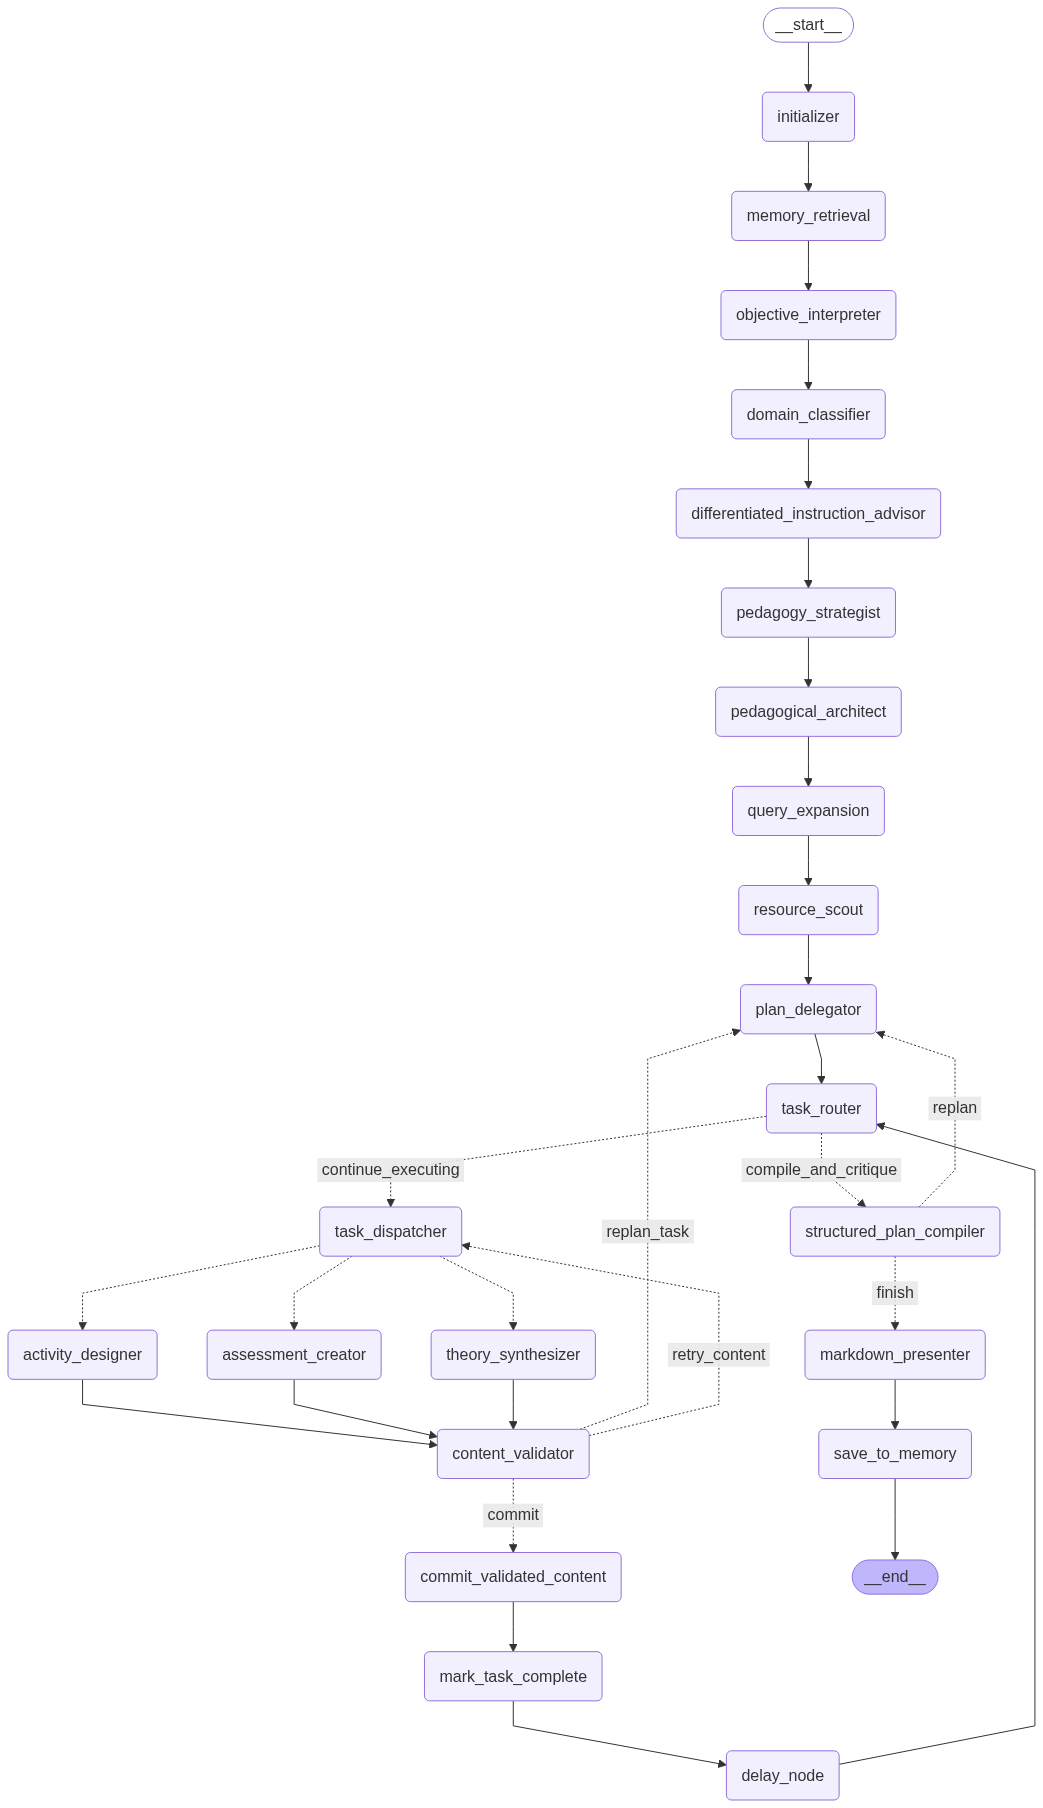

In [17]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [18]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_markdown_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v9.0)[/bold green]")
            console.print(Markdown(final_state_result["final_markdown_plan"]))
            
            # (Tùy chọn) In ra cả JSON để kiểm tra
            if VERBOSE_MODE:
                print_result(final_state_result.get("final_structured_plan"), "Output JSON có cấu trúc")

        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [19]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

⚠️  Không có Trí nhớ Dài hạn. Bỏ qua bước này.

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học khá yếu về kiến thức nền tảng, học sinh dễ mất tập trung và cần các hoạt động có tính tương tác cao để duy trì sự chú ý và hứng thú trong suốt buổi học.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần dễ hiểu, sử dụng nhiều ví dụ trực quan và hình ảnh minh họa. Cung cấp phiếu bài tập có gợi ý, công thức sẵn và các bước giải mẫu. Tổ chức các hoạt động nhóm nhỏ, cặp đôi để tăng cường tương tác và hỗ trợ lẫn nhau. Thường xuyên kiểm tra nhanh và củng cố kiến thức sau mỗi phần.',
│   │   'for_advanced_students': "Giao các bài tập nâng cao hơn một chút, yêu cầu suy luận hoặc chứng minh. Khuyến khích các em tìm hiểu thêm các tính chất mở rộng hoặc ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp. Cho phép các em hỗ trợ các bạn yếu hơn trong nhóm, đóng vai trò 'trợ giảng' và giải thích lại kiến thức."
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp dạy học hợp tác rất phù hợp với lớp học có tốc độ học chậm, kiến thức nền tảng yếu và dễ mất tập trung. Nó khuyến khích học sinh chủ động tham gia vào quá trình học tập thông qua tương tác nhóm, giúp các em không cảm thấy bị bỏ lại phía sau. Việc chia sẻ kiến thức và hỗ trợ lẫn nhau trong nhóm sẽ giúp củng cố kiến thức cho cả học sinh yếu và học sinh khá. Đồng thời, các hoạt động nhóm cũng tạo sự hứng thú, duy trì sự chú ý và giảm bớt tính thụ động của học sinh, đáp ứng yêu cầu về các hoạt động có tính tương tác cao. Giáo viên có thể dễ dàng theo dõi, hỗ trợ và phân hóa học tập cho từng nhóm, từng cá nhân.',
│   'key_actions': [
│   │   'Giới thiệu bài học và định hướng nhiệm vụ nhóm rõ ràng.',
│   │   'Tổ chức các nhóm học tập nhỏ, đa dạng về năng lực học sinh.',
│   │   'Cung cấp tài liệu học tập (phiếu học tập, hình ảnh trực quan) và các nhiệm vụ cụ thể, chia nhỏ kiến thức cho từng nhóm.',
│   │   'Học sinh làm việc nhóm, thảo luận, hỗ trợ lẫn nhau để hoàn thành nhiệm vụ dưới sự hướng dẫn của giáo viên.',
│   │   'Đại diện nhóm trình bày kết quả, chia sẻ cách giải quyết vấn đề hoặc kiến thức đã tìm hiểu.',
│   │   'Giáo viên tổng kết, chuẩn hóa kiến thức, giải đáp thắc mắc và củng cố các khái niệm trọng tâm.',
│   │   'Học sinh thực hành cá nhân thông qua bài tập vận dụng hoặc câu hỏi nhanh để kiểm tra mức độ hiểu bài.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động và Khám phá: Giáo viên sử dụng các câu hỏi gợi mở, hình ảnh hoặc vật thật (ví dụ: compa, thước, các hình tam giác cắt sẵn) để học sinh nhớ lại kiến thức cơ bản về đường tròn và tam giác. Giới thiệu khái niệm "ngoại tiếp", "nội tiếp" thông qua ví dụ trực quan, đơn giản, không đi sâu vào định nghĩa toán học ngay lập tức. Mục tiêu là tạo sự tò mò và kết nối với kiến thức đã biết.',
│   'Xây dựng Kiến thức Mới: Chia lớp thành các nhóm nhỏ theo chiến lược dạy học hợp tác. Cung cấp phiếu học tập có các hoạt động cụ thể, chia nhỏ kiến thức: một phần về đường tròn ngoại tiếp, một phần về đường tròn nội tiếp. Phiếu có thể bao gồm các bước vẽ, quan sát, điền vào chỗ trống hoặc trả lời câu hỏi gợi ý để học sinh tự rút ra định nghĩa và tính chất. Giáo viên đi vòng quanh các nhóm, quan sát, gợi ý, hỗ trợ kịp thời cho các nhóm gặp khó khăn, đặc biệt là học sinh yếu.',
│   'Củng cố và Chuẩn hóa: Mời đại diện các nhóm trình bày kết quả thảo luận của nhóm mình về đường tròn ngoại tiếp và đường tròn nội tiếp. Giáo viên tổng hợp, chuẩn hóa các định nghĩa, tính chất, tâm và bán kính của hai loại đường tròn này. Sử dụng bảng, máy chiếu để ghi lại kiến thức một cách rõ ràng, mạch lạc. Giải đáp các thắc mắc của học sinh, nhấn mạnh các lỗi sai thường gặp hoặc các điểm cần lưu ý.',
│   'Vận dụng và Luyện tập: Cung cấp các bài tập vận dụng từ dễ đến khó, bao gồm cả bài tập nhận biết hình, tính toán đơn giản. Có thể cho học sinh làm việc cá nhân hoặc theo cặp để tăng cường tương tác. Giáo viên theo dõi, hỗ trợ, khuyến khích học sinh khá giúp đỡ các bạn yếu hơn. Có thể tổ chức một vài câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài và duy trì sự tập trung. Giao bài tập về nhà để học sinh tự luyện tập thêm.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp là gì',
│   'đường tròn nội tiếp là gì',
│   'công thức bán kính đường tròn ngoại tiếp tam giác',
│   'công thức bán kính đường tròn nội tiếp tam giác',
│   'tính chất đường tròn ngoại tiếp tam giác',
│   'tính chất đường tròn nội tiếp tam giác',
│   'bài tập đường tròn ngoại tiếp và nội tiếp lớp 9',
│   'cách vẽ đường tròn ngoại tiếp tam giác',
│   'cách vẽ đường tròn nội tiếp tam giác',
│   'đường tròn ngoại tiếp tứ giác',
│   'đường tròn nội tiếp tứ giác',
│   'tâm đường tròn ngoại tiếp tam giác',
│   'tâm đường tròn nội tiếp tam giác',
│   'ứng dụng đường tròn ngoại tiếp trong thực tế',
│   'chuyên đề đường tròn ngoại tiếp nội tiếp hình học',
│   'định nghĩa đường tròn ngoại tiếp',
│   'định nghĩa đường tròn nội tiếp',
│   'quan hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'bài tập nâng cao đường tròn ngoại tiếp nội tiếp',
│   'đường tròn ngoại tiếp hình vuông',
│   'đường tròn nội tiếp hình vuông',
│   'đường tròn ngoại tiếp hình chữ nhật',
│   'đường tròn nội tiếp hình thoi'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 115 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em, dựa trên các đoạn văn bản được cung cấp, thầy/cô xin tóm tắt kiến thức cốt lõi về chủ đề "Đường tròn ngoại tiếp và đường tròn nội tiếp" như sau:\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ ĐƯỜNG TRÒN (LIÊN QUAN ĐẾN CHỦ ĐỀ)**\n\n**I. Khái niệm cơ bản về Đường tròn**\n1.  **Định nghĩa:** Đường tròn tâm O bán kính R ($R > 0$), kí hiệu là $(O, R)$ hoặc $(O)$, là hình gồm tất cả các điểm cách điểm O một khoảng bằng R.\n2.  **Điểm thuộc đường tròn:** Nếu A là một điểm của đường tròn (O) thì ta viết $A \\in (O)$. Khi đó, ta còn nói đường tròn (O) đi qua điểm A, hay điểm A nằm trên đường tròn (O).\n\n**II. Vị trí của một điểm đối với Đường tròn**\nĐối với đường tròn (O; R) và điểm M:\n*   Điểm M nằm trên đường tròn (O; R) nếu $OM = R$.\n*   Điểm M nằm trong đường tròn (O; R) nếu $OM < R$.\n*   Điểm M nằm ngoài đường tròn (O; R) nếu $OM > R$.\n\n**III. Đường tròn đường kính**\n1.  **Định nghĩa:** Đoạn AB là một đường kính của đường tròn (O) nếu O là trung điểm của đoạn AB và đường tròn $(O; OA)$ đi qua B. Khi đó, (O) còn gọi là **đường tròn đường kính AB**.\n2.  **Tính chất liên quan đến tam giác vuông:** Đối với tam giác ABC vuông tại A, điểm A (đỉnh góc vuông) thuộc đường tròn đường kính BC.\n\n---'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 5 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập và Khám phá ban đầu',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên, quan sát hình ảnh/vật thật (compa, thước, tam giác cắt sẵn) để ôn lại kiến thức về đường tròn và tam giác. Qua đó, học sinh làm quen trực quan với khái niệm "ngoại tiếp" và "nội tiếp" thông qua các ví dụ đơn giản.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Thảo luận nhóm và Khám phá Đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, thực hiện các hoạt động trên phiếu học tập để tự khám phá và rút ra định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp tam giác. Các hoạt động bao gồm vẽ hình, quan sát, điền thông tin và trả lời câu hỏi gợi ý.',
│   │   'estimated_duration': 18,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Thảo luận nhóm và Khám phá Đường tròn nội tiếp',
│   │   'task_description': 'Tiếp tục làm việc theo nhóm, học sinh thực hiện các hoạt động trên phiếu học tập để tự khám phá và rút ra định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn nội tiếp tam giác. Các hoạt động bao gồm vẽ hình, quan sát, điền thông tin và trả lời câu hỏi gợi ý.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Trình bày, Tổng hợp và Chuẩn hóa Kiến thức',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận của mình. Học sinh lắng nghe, so sánh, đặt câu hỏi và cùng giáo viên tổng hợp, chuẩn hóa các định nghĩa, tính chất, tâm và bán kính của đường tròn ngoại tiếp và nội tiếp tam giác. Học sinh ghi chép lại kiến thức chuẩn hóa.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng và Luyện tập Bài tập',
│   │   'task_description': 'Học sinh làm các bài tập vận dụng từ dễ đến khó (cá nhân hoặc theo cặp), bao gồm nhận biết hình, tính toán đơn giản liên quan đến đường tròn ngoại tiếp và nội tiếp. Học sinh tham gia các câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài. Ghi lại bài tập về nhà.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập và Khám phá ban đầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Ôn tập và Khám phá ban đầu',
│   'description': "Học sinh sẽ thực hiện các bước sau:\n1. Quan sát các vật dụng (compa, thước thẳng, các loại tam giác giấy cắt sẵn) và trả lời các câu hỏi gợi mở của giáo viên để ôn lại kiến thức cơ bản về đường tròn (tâm, bán kính, đường kính) và tam giác (các loại tam giác).\n2. Thực hành đặt compa tại các vị trí khác nhau của tam giác giấy để thử vẽ đường tròn 'bao quanh' hoặc 'nằm trong' tam giác.\n3. Thảo luận nhóm nhỏ (hoặc cặp đôi) về những gì quan sát được và cố gắng mô tả bằng lời khái niệm 'đường tròn ngoại tiếp' và 'đường tròn nội tiếp' dựa trên các ví dụ trực quan.",
│   'duration_minutes': 10,
│   'activity_type': 'Khám phá và Ôn tập',
│   'teacher_actions': [
│   │   'Chuẩn bị sẵn compa, thước thẳng, các loại tam giác giấy cắt sẵn (đều, cân, vuông, thường) cho mỗi nhóm/cặp học sinh.',
│   │   "Đặt các câu hỏi gợi mở để ôn tập: 'Đường tròn có những yếu tố nào?', 'Các em còn nhớ những loại tam giác nào?', 'Làm sao để vẽ một đường tròn đi qua 3 đỉnh của tam giác?', 'Làm sao để vẽ một đường tròn tiếp xúc với 3 cạnh của tam giác?'.",
│   │   'Hướng dẫn học sinh thực hành với compa và tam giác giấy, khuyến khích các em thử nghiệm.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, đưa ra gợi ý khi học sinh gặp khó khăn hoặc đi chệch hướng.',
│   │   "Tổng hợp các ý kiến của học sinh, giới thiệu chính thức thuật ngữ 'đường tròn ngoại tiếp' và 'đường tròn nội tiếp' dựa trên các quan sát của các em."
│   ],
│   'solution_guide': "Các câu hỏi gợi mở và định hướng quan sát:\n- 'Đường tròn được xác định bởi những yếu tố nào?' (Tâm, bán kính)\n- 'Khi nào một đường tròn được gọi là 'bao quanh' một tam giác?' (Khi nó đi qua các đỉnh của tam giác)\n- 'Khi nào một đường tròn được gọi là 'nằm trong' một tam giác?' (Khi nó tiếp xúc với các cạnh của tam giác)\n- Học sinh cần nhận ra rằng đường tròn ngoại tiếp đi qua 3 đỉnh của tam giác, còn đường tròn nội tiếp tiếp xúc với 3 cạnh của tam giác.",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu học tập có hình ảnh minh họa sẵn các loại tam giác và các bộ phận của đường tròn để học sinh dễ dàng nhận diện và gọi tên. Đặt các câu hỏi đơn giản, trực tiếp hơn như: 'Đây là hình gì?', 'Đường tròn này đi qua đâu của tam giác?', 'Đường tròn này nằm ở đâu so với tam giác?'. Cho phép học sinh làm việc theo cặp với bạn khá hơn để nhận được sự hỗ trợ trực tiếp.",
│   │   'for_advanced_students': "Yêu cầu học sinh thử dự đoán: 'Theo em, tâm của đường tròn ngoại tiếp/nội tiếp sẽ nằm ở vị trí đặc biệt nào của tam giác?' (chưa cần giải thích sâu, chỉ là dự đoán ban đầu). Khuyến khích các em giải thích bằng lời tại sao một đường tròn lại được gọi là 'ngoại tiếp' hay 'nội tiếp' dựa trên quan sát của mình. Giao nhiệm vụ hỗ trợ các bạn trong nhóm khi cần, giải thích lại các khái niệm cơ bản bằng ngôn ngữ của mình."
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 10 phút là quá ngắn cho một hoạt động bao gồm cả ôn tập kiến thức 
cũ, thực hành trực quan với compa và tam giác để khám phá khái niệm mới, thảo luận nhóm, và cuối cùng là tổng hợp 
kiến thức dưới sự hướng dẫn của giáo viên. Học sinh cần nhiều thời gian hơn để thử nghiệm, quan sát, và diễn đạt ý 
tưởng của mình một cách hiệu quả. | SUGGESTED_DURATION: 25

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 4 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập và Khám phá khái niệm ban đầu',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở của giáo viên về đường tròn và tam giác, quan sát hình ảnh/vật thật (compa, thước, tam giác cắt sẵn) để nhớ lại kiến thức cũ và làm quen với các ví dụ trực quan về đường tròn ngoại tiếp, nội tiếp.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Thảo luận nhóm và Xây dựng kiến thức mới',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, thực hiện các hoạt động trên phiếu học tập. Các hoạt động bao gồm vẽ hình, quan sát, điền vào chỗ trống và trả lời câu hỏi gợi ý để tự mình rút ra định nghĩa, tính chất về đường tròn ngoại tiếp và đường tròn nội tiếp của tam giác.',
│   │   'estimated_duration': 40,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Trình bày và Chuẩn hóa kiến thức',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận của nhóm mình. Học sinh lắng nghe, so sánh với kết quả của nhóm mình và ghi chép lại các định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp đã được giáo viên chuẩn hóa.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng và Luyện tập',
│   │   'task_description': 'Học sinh thực hiện các bài tập vận dụng từ dễ đến khó (nhận biết hình, tính toán đơn giản) theo cá nhân hoặc cặp. Tham gia các câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài và nhận bài tập về nhà để tự luyện tập thêm.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập và Khám phá khái niệm ban đầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Ôn tập và Khám phá khái niệm ban đầu',
│   'description': 'Học sinh sẽ tham gia vào các hoạt động sau:\n1. Lắng nghe và trả lời các câu hỏi gợi mở của giáo viên về khái niệm đường tròn và tam giác đã học.\n2. Quan sát các hình ảnh minh họa và vật thật (compa, thước, các loại tam giác cắt sẵn bằng giấy) được giáo viên cung cấp.\n3. Thực hành cá nhân hoặc theo cặp: Sử dụng compa và thước để thử vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ, hoặc một đường tròn tiếp xúc với ba cạnh của tam giác.\n4. Chia sẻ những quan sát ban đầu và suy nghĩ của mình về mối liên hệ giữa đường tròn và tam giác trong các trường hợp vừa thực hành.',
│   'duration_minutes': 15,
│   'activity_type': 'Khám phá và Ôn tập kiến thức nền',
│   'teacher_actions': [
│   │   'Chuẩn bị đầy đủ các vật liệu trực quan: compa, thước, các loại tam giác cắt sẵn (tam giác thường, tam giác vuông, tam giác đều, tam giác cân) cho mỗi nhóm/cặp học sinh.',
│   │   "Đặt các câu hỏi gợi mở để ôn tập kiến thức cũ về đường tròn (tâm, bán kính, dây cung) và tam giác (các loại tam giác, tính chất cơ bản). Ví dụ: 'Đường tròn là gì?', 'Làm thế nào để xác định một đường tròn?', 'Các loại tam giác mà các em đã biết?'",
│   │   'Hướng dẫn học sinh quan sát các hình ảnh/vật thật về đường tròn ngoại tiếp và nội tiếp (chưa gọi tên khái niệm).',
│   │   "Phát phiếu bài tập nhỏ hoặc yêu cầu học sinh thực hành vẽ trên giấy nháp: 'Hãy thử vẽ một đường tròn đi qua ba đỉnh của tam giác này' và 'Hãy thử vẽ một đường tròn tiếp xúc với ba cạnh của tam giác kia'.",
│   │   'Đi vòng quanh lớp, quan sát, lắng nghe các cuộc thảo luận của học sinh và kịp thời hỗ trợ khi cần thiết.',
│   │   'Tổ chức cho học sinh chia sẻ những gì các em đã quan sát và thực hành được, khuyến khích các em diễn đạt bằng lời của mình.',
│   │   'Tổng hợp các ý kiến, dẫn dắt học sinh đến việc nhận diện sự tồn tại của hai loại đường tròn đặc biệt này (chưa đi sâu vào tính chất hay cách xác định tâm).'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở cho học sinh:\n1.  Khi vẽ đường tròn đi qua ba đỉnh của tam giác, em thấy tâm của đường tròn nằm ở đâu so với tam giác?\n2.  Khi vẽ đường tròn tiếp xúc với ba cạnh của tam giác, em thấy tâm của đường tròn nằm ở đâu so với tam giác?\n3.  Em có nhận xét gì về bán kính của hai loại đường tròn này so với kích thước của tam giác?',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các tam giác đã được đánh dấu sẵn các điểm hoặc đường gợi ý (ví dụ: trung điểm cạnh huyền của tam giác vuông, giao điểm của các đường trung trực/phân giác) để học sinh dễ dàng đặt compa và vẽ. Giáo viên có thể trực tiếp hướng dẫn từng bước nhỏ cho nhóm này, hoặc ghép cặp với học sinh khá hơn để nhận được sự hỗ trợ trực tiếp. Đặt các câu hỏi đơn giản, tập trung vào việc nhận diện hình ảnh: 'Em thấy đường tròn này đi qua những điểm nào của tam giác?'",
│   │   'for_advanced_students': "Khuyến khích học sinh thử nghiệm với các loại tam giác khác nhau (vuông, cân, đều) và dự đoán vị trí tâm của đường tròn ngoại tiếp/nội tiếp trước khi vẽ. Đặt câu hỏi mở rộng: 'Theo em, tâm của đường tròn đi qua ba đỉnh tam giác có mối liên hệ gì với các đường đặc biệt trong tam giác (trung tuyến, đường cao, đường trung trực, đường phân giác)?' hoặc 'Có phải lúc nào cũng vẽ được đường tròn đi qua ba đỉnh/tiếp xúc ba cạnh của một tam giác không? Tại sao?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 15 phút là quá ngắn để học sinh có thể thực hiện đầy đủ các hoạt 
động ôn tập, quan sát, thực hành vẽ đường tròn ngoại tiếp/nội tiếp và chia sẻ kết quả. Hoạt động thực hành vẽ đòi 
hỏi thời gian thử nghiệm và sai sót, cũng như thời gian để giáo viên hỗ trợ từng nhóm. Cần thêm thời gian để đảm 
bảo học sinh có đủ trải nghiệm khám phá và tổng kết kiến thức ban đầu. | SUGGESTED_DURATION: 25

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 7 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập kiến thức nền tảng',
│   │   'task_description': 'Học sinh trả lời các câu hỏi gợi mở của giáo viên và quan sát hình ảnh/vật thật (compa, thước, tam giác cắt sẵn) để nhớ lại các khái niệm cơ bản về đường tròn và tam giác.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Làm quen khái niệm ngoại tiếp/nội tiếp',
│   │   'task_description': 'Học sinh quan sát các ví dụ trực quan do giáo viên cung cấp để hình dung khái niệm "đường tròn ngoại tiếp" và "đường tròn nội tiếp" một cách đơn giản, tạo sự tò mò.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Thảo luận nhóm và khám phá kiến thức mới',
│   │   'task_description': 'Học sinh chia nhóm, nhận phiếu học tập và cùng nhau thực hiện các hoạt động vẽ, quan sát, điền vào chỗ trống hoặc trả lời câu hỏi gợi ý để tự rút ra định nghĩa và tính chất của đường tròn ngoại tiếp và nội tiếp.',
│   │   'estimated_duration': 35,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Báo cáo kết quả thảo luận',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận của nhóm mình về định nghĩa và tính chất của đường tròn ngoại tiếp và đường tròn nội tiếp.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Chuẩn hóa kiến thức trọng tâm',
│   │   'task_description': 'Học sinh lắng nghe giáo viên tổng hợp, chuẩn hóa các định nghĩa, tính chất, tâm và bán kính của hai loại đường tròn, đồng thời đặt câu hỏi về các thắc mắc.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Thực hành bài tập vận dụng',
│   │   'task_description': 'Học sinh làm các bài tập vận dụng từ dễ đến khó (nhận biết hình, tính toán đơn giản) theo cá nhân hoặc cặp, có sự hỗ trợ từ giáo viên và bạn bè.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Ghi chép bài tập về nhà',
│   │   'task_description': 'Học sinh ghi lại các bài tập về nhà được giao để tự luyện tập và củng cố kiến thức thêm.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập kiến thức nền tảng' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Ôn tập kiến thức nền tảng và Khám phá ban đầu',
│   'description': 'Học sinh làm việc theo nhóm nhỏ (3-4 em). Mỗi nhóm nhận được bộ dụng cụ gồm compa, thước kẻ, và các mẫu tam giác cắt sẵn (tam giác đều, tam giác cân, tam giác vuông, tam giác thường). Học sinh sẽ cùng nhau quan sát các vật liệu, thảo luận và trả lời các câu hỏi gợi mở của giáo viên để ôn lại các khái niệm cơ bản về đường tròn (tâm, bán kính, dây cung) và tam giác (đỉnh, cạnh, góc, các loại tam giác). Sau đó, các nhóm sẽ thử dùng compa và thước để vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ hoặc một đường tròn tiếp xúc với ba cạnh của một tam giác, từ đó hình thành ý niệm ban đầu về đường tròn ngoại tiếp và nội tiếp.',
│   'duration_minutes': 5,
│   'activity_type': 'Ôn tập và Khám phá',
│   'teacher_actions': [
│   │   'Chuẩn bị và phân phát bộ dụng cụ (compa, thước, các mẫu tam giác cắt sẵn) cho từng nhóm.',
│   │   'Đặt các câu hỏi gợi mở để học sinh ôn tập: "Đường tròn là gì? Tâm, bán kính của đường tròn là gì?", "Tam giác có những yếu tố nào? Kể tên các loại tam giác mà em biết."',
│   │   'Hướng dẫn học sinh thử nghiệm: "Theo em, có thể vẽ một đường tròn đi qua 3 đỉnh của một tam giác không? Hoặc một đường tròn tiếp xúc với 3 cạnh của tam giác không? Hãy thử dùng compa và thước để thực hiện trên các mẫu tam giác."',
│   │   'Quan sát, lắng nghe các nhóm thảo luận và thực hành, đi lại các nhóm để hỗ trợ, giải đáp thắc mắc và đưa ra gợi ý khi cần thiết.',
│   │   'Yêu cầu một vài nhóm chia sẻ kết quả thử nghiệm và những nhận xét ban đầu của mình về vị trí của tâm đường tròn so với tam giác.',
│   │   'Tổng kết các khái niệm cơ bản đã ôn tập và dẫn dắt vào khái niệm đường tròn ngoại tiếp và nội tiếp dựa trên những gì học sinh đã khám phá.'
│   ],
│   'solution_guide': {
│   │   'Câu hỏi gợi mở': [
│   │   │   'Đường tròn được xác định bởi những yếu tố nào?',
│   │   │   'Làm thế nào để vẽ một đường tròn đi qua 3 điểm không thẳng hàng?',
│   │   │   'Làm thế nào để vẽ một đường tròn tiếp xúc với 3 cạnh của một tam giác?',
│   │   │   'Khi vẽ thử, các em có nhận thấy điều gì đặc biệt về vị trí của tâm đường tròn so với tam giác không?'
│   │   ],
│   │   'Hướng dẫn thực hành': [
│   │   │   'Để vẽ đường tròn ngoại tiếp: Hãy thử tìm một điểm cách đều ba đỉnh của tam giác.',
│   │   │   'Để vẽ đường tròn nội tiếp: Hãy thử tìm một điểm cách đều ba cạnh của tam giác.'
│   │   ]
│   },
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu gợi ý với các câu hỏi ôn tập có sẵn định nghĩa hoặc hình ảnh minh họa các loại tam giác. Hướng dẫn trực tiếp cách sử dụng compa và thước để thử vẽ. Gợi ý các bước nhỏ hơn khi thử vẽ: 'Đầu tiên, hãy thử tìm một điểm cách đều ba đỉnh của tam giác.'",
│   │   'for_advanced_students': 'Yêu cầu các em giải thích tại sao lại có thể vẽ được đường tròn đi qua 3 đỉnh hoặc tiếp xúc 3 cạnh của tam giác. Thử thách các em tìm ra mối liên hệ giữa tâm của các đường tròn này với các đường đặc biệt trong tam giác (ví dụ: đường trung trực, đường phân giác). Khuyến khích các em hỗ trợ các bạn yếu hơn trong nhóm.'
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút là hoàn toàn không đủ cho hoạt động này. Mặc dù nhiệm vụ gốc
chỉ là "ôn tập kiến thức nền tảng" trong 5 phút, nhưng nội dung được tạo ra đã mở rộng đáng kể thành "Ôn tập kiến 
thức nền tảng và Khám phá ban đầu". Hoạt động này bao gồm nhiều bước phức tạp hơn như: phân phát dụng cụ, học sinh 
làm việc nhóm, thảo luận, và đặc biệt là thử nghiệm vẽ đường tròn ngoại tiếp/nội tiếp bằng compa và thước. Việc 
khám phá và thực hành vẽ hình học này đòi hỏi nhiều thời gian để học sinh thử, sai, thảo luận và rút ra nhận xét 
ban đầu. Sau đó còn có phần chia sẻ và tổng kết. Với tất cả các bước này, 5 phút là bất khả thi để thực hiện một 
cách hiệu quả. | SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 6 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Khám phá khái niệm ban đầu',
│   │   'task_description': 'Học sinh ôn tập kiến thức cơ bản về đường tròn và tam giác thông qua các câu hỏi gợi mở của giáo viên. Quan sát các hình ảnh, vật thật (compa, thước, tam giác cắt sẵn) để hình dung và thảo luận ban đầu về khái niệm "ngoại tiếp", "nội tiếp" một cách trực quan.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Hoạt động nhóm: Khám phá Đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, nhận phiếu học tập về đường tròn ngoại tiếp. Thực hiện các bước vẽ, quan sát, điền vào chỗ trống và trả lời câu hỏi gợi ý để tự rút ra định nghĩa, tính chất và cách xác định tâm, bán kính của đường tròn ngoại tiếp tam giác.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Hoạt động nhóm: Khám phá Đường tròn nội tiếp',
│   │   'task_description': 'Học sinh tiếp tục làm việc theo nhóm nhỏ, nhận phiếu học tập về đường tròn nội tiếp. Thực hiện các bước vẽ, quan sát, điền vào chỗ trống và trả lời câu hỏi gợi ý để tự rút ra định nghĩa, tính chất và cách xác định tâm, bán kính của đường tròn nội tiếp tam giác.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Trình bày, Củng cố và Chuẩn hóa kiến thức',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận của nhóm mình về đường tròn ngoại tiếp và nội tiếp. Học sinh lắng nghe, đặt câu hỏi và cùng giáo viên tổng hợp, chuẩn hóa các định nghĩa, tính chất, tâm và bán kính của hai loại đường tròn này, ghi chép vào vở.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng và Luyện tập tại lớp',
│   │   'task_description': 'Học sinh làm các bài tập vận dụng từ dễ đến khó (nhận biết hình, tính toán đơn giản) theo cá nhân hoặc cặp. Học sinh khá hỗ trợ học sinh yếu hơn. Tham gia các câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Ghi nhận Bài tập về nhà',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà được giao để tự luyện tập thêm và chuẩn bị cho buổi học tiếp theo.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Khám phá khái niệm ban đầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Khám phá khái niệm ban đầu về Đường tròn ngoại tiếp, nội tiếp',
│   'description': 'Học sinh sẽ ôn tập kiến thức cơ bản về đường tròn và tam giác. Sau đó, các em sẽ làm việc theo nhóm nhỏ, sử dụng compa, thước và các tam giác cắt sẵn để thực hành vẽ thử và khám phá trực quan về khái niệm đường tròn ngoại tiếp và đường tròn nội tiếp. Cụ thể:\n1.  **Ôn tập kiến thức nền tảng (2 phút):** Học sinh lắng nghe và trả lời các câu hỏi gợi mở của giáo viên về các yếu tố cơ bản của đường tròn (tâm, bán kính) và tam giác (đỉnh, cạnh).\n2.  **Quan sát và Thảo luận ban đầu (3 phút):** Quan sát các hình ảnh minh họa hoặc vật thật (compa, thước, các tam giác cắt sẵn). Thảo luận nhóm về ý nghĩa của các cụm từ "đường tròn đi qua các đỉnh của tam giác" và "đường tròn tiếp xúc với các cạnh của tam giác".\n3.  **Thực hành Khám phá (7 phút):**\n    *   **Nhiệm vụ 1 (Đường tròn ngoại tiếp):** Mỗi nhóm nhận một tam giác cắt sẵn. Thử dùng compa và thước để vẽ một đường tròn đi qua cả ba đỉnh của tam giác đó. Ghi lại những gì các em quan sát được về vị trí tâm của đường tròn này so với tam giác.\n    *   **Nhiệm vụ 2 (Đường tròn nội tiếp):** Tương tự, thử vẽ một đường tròn tiếp xúc với cả ba cạnh của tam giác. Ghi lại những gì các em quan sát được về vị trí tâm của đường tròn này so với tam giác.\n4.  **Chia sẻ và Rút ra nhận xét ban đầu (3 phút):** Các nhóm chia sẻ kết quả thử nghiệm, những khó khăn gặp phải và những nhận xét ban đầu về đặc điểm của hai loại đường tròn này.',
│   'duration_minutes': 15,
│   'activity_type': 'Khám phá và Thảo luận nhóm',
│   'teacher_actions': [
│   │   'Chuẩn bị và phân phát các dụng cụ học tập (compa, thước, các tam giác cắt sẵn với nhiều hình dạng khác nhau: tam giác vuông, tam giác nhọn, tam giác tù) cho mỗi nhóm.',
│   │   'Đặt các câu hỏi gợi mở để ôn tập kiến thức cũ: "Đường tròn được xác định bởi những yếu tố nào?", "Tam giác có những yếu tố nào?", "Thế nào là \'đi qua\' một điểm?", "Thế nào là \'tiếp xúc\' với một đường thẳng?".',
│   │   'Yêu cầu học sinh quan sát hình ảnh/vật thật và thảo luận nhóm về ý nghĩa của "ngoại tiếp" và "nội tiếp".',
│   │   'Hướng dẫn học sinh thực hiện nhiệm vụ vẽ đường tròn ngoại tiếp và nội tiếp bằng compa và thước trên các tam giác cắt sẵn. Nhấn mạnh đây là hoạt động khám phá, không yêu cầu vẽ chính xác ngay lập tức mà là để hình dung.',
│   │   'Đi quanh các nhóm, quan sát, lắng nghe thảo luận, và đưa ra gợi ý khi cần thiết, đặc biệt là hỗ trợ các nhóm gặp khó khăn trong việc sử dụng compa hoặc hình dung.',
│   │   'Yêu cầu các nhóm chia sẻ những gì các em đã thử, những khó khăn gặp phải và những nhận xét ban đầu về vị trí tâm của đường tròn ngoại tiếp/nội tiếp.',
│   │   'Tổng hợp các ý kiến, dẫn dắt học sinh đến nhận định ban đầu về sự tồn tại và tính chất trực quan của hai loại đường tròn này.'
│   ],
│   'solution_guide': {
│   │   'questions': [
│   │   │   'Khi vẽ đường tròn đi qua 3 đỉnh của tam giác (ngoại tiếp), tâm của đường tròn đó nằm ở đâu so với tam giác (bên trong, bên ngoài, trên cạnh)?',
│   │   │   'Khi vẽ đường tròn tiếp xúc với 3 cạnh của tam giác (nội tiếp), tâm của đường tròn đó nằm ở đâu so với tam giác?',
│   │   │   'Các em có nhận xét gì về khoảng cách từ tâm đến các đỉnh (đối với đường tròn ngoại tiếp) hoặc đến các cạnh (đối với đường tròn nội tiếp)?'
│   │   ],
│   │   'expected_initial_observations': 'Học sinh sẽ nhận thấy đường tròn ngoại tiếp đi qua 3 đỉnh của tam giác, còn đường tròn nội tiếp tiếp xúc với 3 cạnh của tam giác. Các em có thể nhận ra rằng tâm của đường tròn ngoại tiếp có thể nằm trong, ngoài hoặc trên cạnh tam giác tùy loại tam giác, trong khi tâm của đường tròn nội tiếp luôn nằm bên trong tam giác.'
│   },
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các tam giác có hình dạng đơn giản hơn (ví dụ: tam giác vuông, tam giác cân) để các em dễ hình dung và thử vẽ. Có thể cung cấp một hình vẽ mờ của đường tròn ngoại tiếp/nội tiếp để các em tô lại hoặc đặt compa theo gợi ý ban

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 15 phút là quá ngắn cho hoạt động khám phá thực hành, đặc biệt là 
phần học sinh tự thử vẽ đường tròn ngoại tiếp và nội tiếp. Hoạt động này đòi hỏi học sinh phải thử nghiệm, có thể 
gặp khó khăn và cần thời gian để quan sát, ghi nhận. 7 phút cho hai nhiệm vụ vẽ thử là không đủ để học sinh thực sự
khám phá và hình dung một cách sâu sắc. Nên tăng thời gian cho phần thực hành để đảm bảo học sinh có đủ không gian 
để thử nghiệm và rút ra nhận xét ban đầu. | SUGGESTED_DURATION: 20

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập kiến thức nền tảng',
│   │   'task_description': 'Học sinh sẽ tham gia trả lời các câu hỏi gợi mở của giáo viên về đường tròn và tam giác, quan sát các hình ảnh/vật thật để nhớ lại kiến thức đã học.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá khái niệm ban đầu',
│   │   'task_description': 'Học sinh quan sát các ví dụ trực quan về đường tròn ngoại tiếp và nội tiếp thông qua hình ảnh, vật thật (compa, thước, các hình tam giác cắt sẵn) để hình dung ý nghĩa ban đầu của các khái niệm này.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Thảo luận nhóm về Đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, thực hiện các hoạt động trên phiếu học tập để vẽ, quan sát và tự rút ra định nghĩa, tính chất, tâm và bán kính của đường tròn ngoại tiếp tam giác.',
│   │   'estimated_duration': 18,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Thảo luận nhóm về Đường tròn nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, thực hiện các hoạt động trên phiếu học tập để vẽ, quan sát và tự rút ra định nghĩa, tính chất, tâm và bán kính của đường tròn nội tiếp tam giác.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Trình bày và thảo luận kết quả nhóm',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận của nhóm mình về đường tròn ngoại tiếp và nội tiếp. Các học sinh khác lắng nghe, so sánh và đặt câu hỏi để làm rõ các vấn đề.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Chuẩn hóa kiến thức',
│   │   'task_description': 'Học sinh ghi chép lại các định nghĩa, tính chất, tâm và bán kính chuẩn hóa của đường tròn ngoại tiếp và nội tiếp do giáo viên tổng hợp và trình bày, đồng thời lắng nghe giải đáp các thắc mắc.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Luyện tập vận dụng kiến thức',
│   │   'task_description': 'Học sinh làm các bài tập vận dụng từ dễ đến khó (bao gồm nhận biết hình, tính toán đơn giản) theo cá nhân hoặc cặp, áp dụng các kiến thức đã học về đường tròn ngoại tiếp và nội tiếp.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Kiểm tra nhanh và giao bài tập về nhà',
│   │   'task_description': 'Học sinh tham gia các câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài và duy trì sự tập trung, sau đó ghi lại bài tập về nhà được giáo viên giao để tự luyện tập thêm.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập kiến thức nền tảng' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Ôn tập kiến thức nền tảng và Khám phá ban đầu về Đường tròn ngoại tiếp, nội tiếp',
│   'description': 'Học sinh sẽ tham gia hoạt động ôn tập và khám phá ban đầu về đường tròn ngoại tiếp và nội tiếp. Các bước cụ thể:\n1.  **Ôn tập kiến thức nền tảng (5 phút):** Học sinh trả lời các câu hỏi gợi mở của giáo viên về khái niệm đường tròn, tam giác, các yếu tố cơ bản (tâm, bán kính, đường kính, đỉnh, cạnh, góc). Quan sát các hình ảnh/vật thật (ví dụ: bánh xe, đồng hồ, miếng pizza hình tam giác) để nhớ lại kiến thức đã học.\n2.  **Thử vẽ và khám phá (15 phút):**\n    a.  **Đường tròn ngoại tiếp:** Học sinh được cung cấp một tam giác bất kỳ (có thể là tam giác vẽ sẵn hoặc tự vẽ). Học sinh sẽ thử tìm cách vẽ một đường tròn đi qua ba đỉnh của tam giác đó. Giáo viên khuyến khích các em thử nhiều cách khác nhau.\n    b.  **Đường tròn nội tiếp:** Học sinh tiếp tục với một tam giác khác. Học sinh sẽ thử tìm cách vẽ một đường tròn tiếp xúc với cả ba cạnh của tam giác đó. Giáo viên khuyến khích các em thử nghiệm và ghi nhận những gì mình quan sát được.\n3.  **Chia sẻ ban đầu (Tích hợp trong quá trình):** Trong quá trình thực hành, học sinh có thể chia sẻ những khó khăn, những phát hiện ban đầu với bạn bè hoặc giáo viên.',
│   'duration_minutes': 5,
│   'activity_type': 'Ôn tập và Khám phá thực hành',
│   'teacher_actions': [
│   │   "Đặt các câu hỏi gợi mở để ôn tập kiến thức cũ về đường tròn và tam giác (ví dụ: 'Đường tròn là gì?', 'Tam giác có những loại nào?', 'Kể tên các yếu tố của đường tròn/tam giác?').",
│   │   'Trình chiếu hình ảnh hoặc đưa ra các vật thật có hình dạng đường tròn, tam giác để học sinh quan sát và liên hệ.',
│   │   'Phát giấy, thước, compa, bút chì cho học sinh.',
│   │   'Hướng dẫn học sinh nhiệm vụ thử vẽ đường tròn ngoại tiếp và nội tiếp, nhấn mạnh việc thử nghiệm và quan sát.',
│   │   "Đi quanh lớp, quan sát học sinh thực hành, đặt câu hỏi gợi mở (ví dụ: 'Em đang thử vẽ bằng cách nào?', 'Em thấy có điểm gì đặc biệt khi vẽ đường tròn đi qua 3 đỉnh?'), và hỗ trợ kịp thời những học sinh gặp khó khăn.",
│   │   'Khuyến khích học sinh chia sẻ những gì mình đã thử và quan sát được trong quá trình thực hành.',
│   │   'Lưu ý những khó khăn chung của học sinh để chuẩn bị cho phần giảng dạy tiếp theo.'
│   ],
│   'solution_guide': "Các câu hỏi gợi mở cho học sinh trong quá trình thực hành:\n-   Để vẽ một đường tròn đi qua ba đỉnh của tam giác, em nghĩ tâm của đường tròn đó phải có đặc điểm gì so với ba đỉnh?\n-   Để vẽ một đường tròn tiếp xúc với ba cạnh của tam giác, em nghĩ tâm của đường tròn đó phải có đặc điểm gì so với ba cạnh?\n-   Em đã thử những cách nào để tìm tâm của đường tròn?\n-   Khi vẽ đường tròn ngoại tiếp, em có nhớ lại khái niệm 'đường trung trực' không?\n-   Khi vẽ đường tròn nội tiếp, em có nhớ lại khái niệm 'đường phân giác' không?",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu bài tập có sẵn các tam giác được vẽ rõ ràng, kèm theo gợi ý các bước cơ bản để tìm tâm (ví dụ: 'Hãy thử vẽ các đường trung trực của các cạnh tam giác' cho đường tròn ngoại tiếp, hoặc 'Hãy thử vẽ các đường phân giác của các góc tam giác' cho đường tròn nội tiếp). Giáo viên có thể gợi ý sử dụng compa và thước để đo đạc chính xác hơn.",
│   │   'for_advanced_students': "Yêu cầu học sinh thử vẽ đường tròn ngoại tiếp và nội tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác cân, tam giác đều) và nhận xét về vị trí của tâm đường tròn trong từng trường hợp. Đặt câu hỏi mở rộng: 'Em có nhận xét gì về mối quan hệ giữa tâm đường tròn ngoại tiếp/nội tiếp với các đường đặc biệt trong tam giác (trung tuyến, đường cao, phân giác, trung trực)?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Hoạt động được mô tả trong phần "description" bao gồm cả ôn tập kiến thức nền 
tảng (5 phút) và khám phá ban đầu về đường tròn ngoại tiếp, nội tiếp (15 phút). Tổng thời lượng thực tế của hoạt 
động này là khoảng 20 phút, không phải 5 phút như đã ghi trong trường "duration_minutes". 5 phút là không đủ để học
sinh thực hiện cả hai phần hoạt động này. | SUGGESTED_DURATION: 20

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 6 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Khám phá ban đầu',
│   │   'task_description': 'Học sinh nhớ lại kiến thức cơ bản về đường tròn và tam giác thông qua câu hỏi gợi mở, hình ảnh và vật thật. Quan sát ví dụ trực quan để làm quen với khái niệm "ngoại tiếp", "nội tiếp" nhằm tạo sự tò mò và kết nối với kiến thức đã biết.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng Kiến thức: Đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, sử dụng phiếu học tập để thực hiện các bước vẽ, quan sát và điền thông tin, từ đó tự rút ra định nghĩa và tính chất của đường tròn ngoại tiếp tam giác.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng Kiến thức: Đường tròn nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, sử dụng phiếu học tập để thực hiện các bước vẽ, quan sát và điền thông tin, từ đó tự rút ra định nghĩa và tính chất của đường tròn nội tiếp tam giác.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Củng cố và Chuẩn hóa Kiến thức',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận. Học sinh lắng nghe, đặt câu hỏi. Giáo viên tổng hợp, chuẩn hóa các định nghĩa, tính chất, tâm và bán kính của hai loại đường tròn, giải đáp thắc mắc và nhấn mạnh các điểm cần lưu ý.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng và Luyện tập tại lớp',
│   │   'task_description': 'Học sinh làm các bài tập vận dụng từ dễ đến khó (bao gồm nhận biết hình, tính toán đơn giản) theo cá nhân hoặc theo cặp. Tham gia các câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Giao bài tập về nhà',
│   │   'task_description': 'Học sinh ghi chép bài tập về nhà được giao và lắng nghe hướng dẫn từ giáo viên để tự luyện tập thêm, củng cố kiến thức đã học.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Khám phá ban đầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Khám phá ban đầu',
│   'description': 'Học sinh sẽ thực hiện hai phần chính:\n\n1.  **Ôn tập kiến thức nền tảng (5 phút):**\n    *   Quan sát các hình ảnh/vật thật (ví dụ: đồng hồ, bánh xe, thước ê-ke, tam giác cắt từ giấy) được giáo viên chuẩn bị.\n    *   Trả lời các câu hỏi gợi mở của giáo viên về đặc điểm của đường tròn (tâm, bán kính, đường kính) và các loại tam giác cơ bản (đều, cân, vuông).\n    *   Nhớ lại mối quan hệ giữa đường tròn và một điểm/đường thẳng (tiếp xúc, cắt, nằm ngoài).\n\n2.  **Khám phá khái niệm mới (15 phút):**\n    *   Quan sát các hình vẽ/mô hình trực quan (ví dụ: tam giác nằm trong đường tròn, đường tròn nằm trong tam giác) do giáo viên trình bày.\n    *   Thảo luận nhóm đôi/nhóm nhỏ để mô tả những gì các em quan sát được về vị trí tương đối của đường tròn và tam giác.\n    *   Cố gắng dùng từ ngữ của mình để diễn tả mối quan hệ giữa đường tròn và tam giác trong các hình ảnh đó.\n    *   Dự đoán ý nghĩa của các cụm từ "đường tròn ngoại tiếp" và "đường tròn nội tiếp" dựa trên quan sát và vốn từ của bản thân.',
│   'duration_minutes': 15,
│   'activity_type': 'Khởi động và Khám phá',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh, vật thật (đồng hồ, bánh xe, thước ê-ke, tam giác giấy) và các mô hình/hình vẽ minh họa đường tròn ngoại tiếp, nội tiếp.',
│   │   'Đặt câu hỏi gợi mở để học sinh ôn tập kiến thức cũ: "Đường tròn có những yếu tố nào?", "Kể tên các loại tam giác mà em biết?", "Khi nào một đường thẳng được gọi là tiếp tuyến của đường tròn?".',
│   │   'Yêu cầu học sinh quan sát các ví dụ trực quan về đường tròn ngoại tiếp/nội tiếp và mô tả.',
│   │   'Gợi ý học sinh thảo luận nhóm đôi/nhóm nhỏ để chia sẻ quan sát và dự đoán ý nghĩa.',
│   │   'Lắng nghe, ghi nhận các ý kiến của học sinh và dẫn dắt vào bài học mới.',
│   │   'Kiểm tra nhanh sự hiểu biết ban đầu của học sinh về các khái niệm.'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở cho học sinh:\n*   **Phần ôn tập:**\n    *   Đường tròn có những yếu tố cơ bản nào? (Tâm, bán kính, đường kính)\n    *   Kể tên các loại tam giác mà em đã học. (Tam giác đều, tam giác cân, tam giác vuông)\n    *   Khi nào một điểm nằm trên đường tròn? Khi nào một đường thẳng tiếp xúc với đường tròn?\n*   **Phần khám phá:**\n    *   Trong hình ảnh, các đỉnh của tam giác nằm ở đâu so với đường tròn? (Nằm trên đường tròn hay bên trong/bên ngoài?)\n    *   Các cạnh của tam giác có mối quan hệ gì với đường tròn? (Tiếp xúc, cắt, hay không liên quan?)\n    *   Theo em, từ "ngoại" và "nội" trong tiếng Việt có nghĩa là gì? (Ngoại: bên ngoài; Nội: bên trong). Từ đó, em dự đoán "ngoại tiếp" và "nội tiếp" có nghĩa là gì trong toán học?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các hình ảnh/vật thật rõ ràng, đơn giản nhất. Đặt các câu hỏi ôn tập kiến thức cũ ở mức độ dễ hơn, có thể là câu hỏi trắc nghiệm hoặc điền vào chỗ trống. Gợi ý trực tiếp bằng cách chỉ vào hình và hỏi: "Điểm này là gì của đường tròn?", "Tam giác này có gì đặc biệt?". Cho phép các em làm việc với bạn giỏi hơn để được hỗ trợ trực tiếp.',
│   │   'for_advanced_students': 'Yêu cầu các em tự vẽ nhanh một ví dụ về đường tròn và tam giác có mối quan hệ đặc biệt (chưa cần chính xác). Đặt câu hỏi mở rộng: "Theo em, tại sao lại có tên gọi \'ngoại tiếp\' và \'nội tiếp\'?", "Em có thể nghĩ ra ví dụ nào khác trong thực tế có hình ảnh tương tự không?". Khuyến khích các em giải thích lại cho bạn bè trong nhóm về những gì mình quan sát được.'
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng tổng cộng của hoạt động (15 phút) không khớp với thời lượng chi tiết
được mô tả trong phần mô tả (5 phút ôn tập + 15 phút khám phá = 20 phút). Với các hoạt động khám phá và thảo luận 
nhóm như đã nêu, 20 phút sẽ là thời lượng hợp lý hơn để học sinh có đủ thời gian tiếp thu và tương tác. | 
SUGGESTED_DURATION: 20

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 9 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập kiến thức nền tảng',
│   │   'task_description': 'Học sinh tham gia trả lời các câu hỏi gợi mở và quan sát hình ảnh/vật thật để ôn tập kiến thức cơ bản về đường tròn và tam giác.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá khái niệm ban đầu',
│   │   'task_description': 'Học sinh quan sát các ví dụ trực quan đơn giản để làm quen với khái niệm "ngoại tiếp" và "nội tiếp" mà không cần định nghĩa toán học chi tiết.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức về đường tròn ngoại tiếp',
│   │   'task_description': 'Trong nhóm nhỏ, học sinh thực hiện các hoạt động trên phiếu học tập (vẽ, quan sát, điền vào chỗ trống) để tự rút ra định nghĩa và tính chất của đường tròn ngoại tiếp tam giác.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Xây dựng kiến thức về đường tròn nội tiếp',
│   │   'task_description': 'Trong nhóm nhỏ, học sinh tiếp tục thực hiện các hoạt động trên phiếu học tập để tự rút ra định nghĩa và tính chất của đường tròn nội tiếp tam giác.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Trình bày kết quả thảo luận nhóm',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận của nhóm mình về đường tròn ngoại tiếp và nội tiếp. Học sinh lắng nghe và đặt câu hỏi.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Tiếp thu và chuẩn hóa kiến thức',
│   │   'task_description': 'Học sinh ghi chép và tiếp thu kiến thức chuẩn hóa về định nghĩa, tính chất, tâm và bán kính của đường tròn ngoại tiếp và nội tiếp do giáo viên tổng hợp và chuẩn hóa.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Luyện tập và vận dụng kiến thức',
│   │   'task_description': 'Học sinh làm việc cá nhân hoặc theo cặp để giải các bài tập vận dụng từ dễ đến khó, bao gồm nhận biết hình và tính toán đơn giản liên quan đến đường tròn ngoại tiếp và nội tiếp.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Kiểm tra nhanh và củng cố',
│   │   'task_description': 'Học sinh tham gia các câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài và củng cố kiến thức đã học.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 8,
│   │   'task_name': 'Ghi nhận bài tập về nhà',
│   │   'task_description': 'Học sinh ghi nhận và chuẩn bị thực hiện bài tập về nhà được giao để tự luyện tập thêm và khắc sâu kiến thức.',
│   │   'estimated_duration': 0,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập kiến thức nền tảng' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Theory Synthesizer tạo ra (có phân hóa):

{
│   'activity_name': 'Ôn tập kiến thức nền tảng về Đường tròn và Tam giác',
│   'description': 'Học sinh sẽ tham gia vào hoạt động ôn tập kiến thức nền tảng về đường tròn và tam giác thông qua việc quan sát hình ảnh/vật thật và trả lời các câu hỏi gợi mở.1. Khởi động (5 phút): Giáo viên trình chiếu các hình ảnh/vật thật có dạng đường tròn (ví dụ: bánh xe, đồng hồ, đĩa CD) và tam giác (ví dụ: biển báo giao thông, mái nhà). Học sinh quan sát và nêu tên các hình đã biết.2. Thảo luận và Gợi mở (15 phút):    Câu hỏi 1: "Các em hãy kể tên các yếu tố cơ bản của một đường tròn mà các em đã học (tâm, bán kính, đường kính, dây cung, cung, tiếp tuyến)?"    Câu hỏi 2: "Một tam giác có những yếu tố cơ bản nào (đỉnh, cạnh, góc)?"    Câu hỏi 3: "Theo các em, có mối liên hệ nào giữa đường tròn và tam giác không? Hãy thử hình dung một tam giác nằm trong hoặc bao quanh một đường tròn."    Học sinh thảo luận theo cặp hoặc nhóm nhỏ (nếu có thời gian) và chia sẻ câu trả lời.    Giáo viên tổng hợp các ý kiến, nhấn mạnh các khái niệm quan trọng.',
│   'duration_minutes': 10,
│   'activity_type': 'Ôn tập và Khám phá',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh/vật thật minh họa đường tròn và tam giác.',
│   │   'Trình chiếu hình ảnh và đặt các câu hỏi gợi mở.',
│   │   'Lắng nghe và ghi nhận các câu trả lời của học sinh.',
│   │   'Khuyến khích học sinh thảo luận và chia sẻ ý kiến.',
│   │   'Tổng hợp các kiến thức nền tảng về đường tròn và tam giác, làm cầu nối cho bài học mới.',
│   │   'Cung cấp các định nghĩa chính xác nếu học sinh còn mơ hồ.'
│   ],
│   'solution_guide': 'Các khái niệm cần được ôn tập và làm rõ: Đường tròn: Tâm, bán kính, đường kính, dây cung, cung, tiếp tuyến. Tam giác: Đỉnh, cạnh, góc. Mối liên hệ ban đầu: Gợi mở về việc đường tròn có thể đi qua các đỉnh của tam giác (ngoại tiếp) hoặc tiếp xúc với các cạnh của tam giác (nội tiếp).',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu học tập có sẵn hình vẽ đường tròn và tam giác, yêu cầu học sinh điền tên các yếu tố vào chỗ trống hoặc khoanh tròn các yếu tố được nhắc đến. Giáo viên có thể đặt các câu hỏi đơn giản hơn, ví dụ: 'Đây là gì của đường tròn?' (chỉ vào tâm/bán kính). Cho phép các em tham khảo sách giáo khoa hoặc vở ghi.",
│   │   'for_advanced_students': "Yêu cầu học sinh suy nghĩ về các tính chất đặc biệt của tam giác (ví dụ: tam giác đều, tam giác vuông) và mối liên hệ của chúng với đường tròn. Đặt câu hỏi mở rộng: 'Theo các em, một đường tròn có thể đi qua bao nhiêu đỉnh của một tam giác? Và ngược lại, một tam giác có thể tiếp xúc với đường tròn tại bao nhiêu điểm?'"
│   }
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng tổng cộng của các bước hoạt động (5 phút Khởi động + 15 phút Thảo 
luận) là 20 phút, không khớp với thời lượng 10 phút được ghi trong trường "duration_minutes". Hoạt động này cũng 
vượt quá thời lượng dự kiến ban đầu là 10 phút. | SUGGESTED_DURATION: 20

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 7 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Khám phá khái niệm ban đầu',
│   │   'task_description': 'Học sinh tham gia hoạt động khởi động, trả lời câu hỏi gợi mở của giáo viên về đường tròn và tam giác, quan sát các vật mẫu (compa, thước, hình tam giác cắt sẵn) để gợi nhớ kiến thức cũ và làm quen với khái niệm "ngoại tiếp", "nội tiếp" qua ví dụ trực quan.',
│   │   'estimated_duration': 12,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức về Đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh chia nhóm, nhận phiếu học tập và thực hiện các hoạt động theo hướng dẫn: vẽ hình, quan sát, điền thông tin vào chỗ trống hoặc trả lời câu hỏi gợi ý để tự mình khám phá và rút ra định nghĩa, tính chất của đường tròn ngoại tiếp tam giác.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức về Đường tròn nội tiếp',
│   │   'task_description': 'Học sinh tiếp tục làm việc nhóm với phiếu học tập, thực hiện các bước tương tự để tự mình khám phá và rút ra định nghĩa, tính chất của đường tròn nội tiếp tam giác.',
│   │   'estimated_duration': 16,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Trình bày và Thảo luận kết quả nhóm',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận của nhóm mình về đường tròn ngoại tiếp và đường tròn nội tiếp. Các học sinh khác lắng nghe và so sánh với kết quả của nhóm mình.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Củng cố và Chuẩn hóa kiến thức',
│   │   'task_description': 'Học sinh lắng nghe giáo viên tổng hợp, chuẩn hóa các định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp, ghi chép lại kiến thức trọng tâm và đặt câu hỏi nếu có thắc mắc.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng và Luyện tập tại lớp',
│   │   'task_description': 'Học sinh thực hiện các bài tập vận dụng từ dễ đến khó (nhận biết hình, tính toán đơn giản) theo cá nhân hoặc cặp, có thể trao đổi và hỗ trợ lẫn nhau dưới sự hướng dẫn của giáo viên.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Kiểm tra nhanh và Giao bài tập về nhà',
│   │   'task_description': 'Học sinh tham gia các câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài, đồng thời ghi nhận bài tập về nhà để tự luyện tập thêm.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Khám phá khái niệm ban đầu' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động và Khám phá khái niệm ban đầu',
│   'description': "Học sinh quan sát các vật mẫu được giáo viên chuẩn bị (compa, thước, các hình tam giác cắt sẵn). Học sinh lắng nghe và trả lời các câu hỏi gợi mở của giáo viên về mối quan hệ giữa đường tròn và tam giác. Học sinh thảo luận nhóm nhỏ để nhận diện và mô tả ban đầu về khái niệm 'đường tròn ngoại tiếp' và 'đường tròn nội tiếp' thông qua các ví dụ trực quan và vật mẫu.",
│   'duration_minutes': 12,
│   'activity_type': 'Khởi động và Khám phá',
│   'teacher_actions': [
│   │   'Chuẩn bị và trưng bày các vật mẫu: compa, thước, các hình tam giác cắt sẵn (có thể có cả hình tròn đã vẽ sẵn đi qua các đỉnh hoặc tiếp xúc các cạnh).',
│   │   "Đặt câu hỏi gợi mở: 'Các em đã biết gì về đường tròn và tam giác?', 'Có khi nào một đường tròn đi qua tất cả các đỉnh của một tam giác không?', 'Hoặc một đường tròn tiếp xúc với tất cả các cạnh của một tam giác không?'",
│   │   'Hướng dẫn học sinh quan sát kỹ các vật mẫu và hình ảnh minh họa.',
│   │   "Giới thiệu sơ bộ các thuật ngữ 'đường tròn ngoại tiếp' và 'đường tròn nội tiếp' dựa trên quan sát của học sinh.",
│   │   'Yêu cầu học sinh thảo luận nhóm nhỏ (khoảng 5 phút) để chia sẻ những gì các em quan sát được và suy đoán ban đầu về hai khái niệm.',
│   │   'Mời đại diện một vài nhóm chia sẻ ý kiến và ghi nhận các từ khóa, ý tưởng của học sinh lên bảng.',
│   │   'Tổng kết các ý tưởng ban đầu của học sinh, chuẩn bị cho phần khám phá sâu hơn.'
│   ],
│   'solution_guide': "Các câu hỏi gợi mở cho học sinh trong quá trình quan sát và thảo luận:\n1. Khi một đường tròn 'ôm trọn' một tam giác, đi qua cả ba đỉnh của tam giác đó, các em sẽ gọi đường tròn đó là gì?\n2. Khi một đường tròn 'nằm gọn' bên trong một tam giác và 'chạm' vào cả ba cạnh của tam giác đó, các em sẽ gọi đường tròn đó là gì?\n3. Các em có nhận xét gì về vị trí của tâm đường tròn so với tam giác trong mỗi trường hợp?",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các hình vẽ đã có sẵn đường tròn ngoại tiếp/nội tiếp và yêu cầu học sinh chỉ ra các đặc điểm (ví dụ: đường tròn đi qua đỉnh, đường tròn tiếp xúc cạnh). Đặt các câu hỏi đơn giản, trực tiếp như 'Đường tròn này đi qua những điểm nào của tam giác?' hoặc 'Đường tròn này tiếp xúc với những cạnh nào của tam giác?'. Cho phép các em làm việc cặp đôi với bạn khá hơn để được hỗ trợ trực tiếp.",
│   │   'for_advanced_students': "Yêu cầu học sinh thử dùng compa và thước để vẽ một đường tròn đi qua ba đỉnh của một tam giác bất kỳ hoặc một đường tròn tiếp xúc với ba cạnh của một tam giác. Đặt câu hỏi mở rộng: 'Theo em, tâm của đường tròn ngoại tiếp/nội tiếp sẽ có vị trí đặc biệt gì so với tam giác? Hãy thử dự đoán.'"
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 12 phút là quá ngắn cho một hoạt động khởi động và khám phá khái 
niệm ban đầu có bao gồm thảo luận nhóm 5 phút, chia sẻ và tổng kết. Học sinh cần thêm thời gian để quan sát, suy 
nghĩ, thảo luận và trình bày ý kiến một cách đầy đủ. | SUGGESTED_DURATION: 18

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: Nhớ lại kiến thức cơ bản',
│   │   'task_description': 'Học sinh sẽ tham gia vào hoạt động khởi động do giáo viên tổ chức, bao gồm việc trả lời các câu hỏi gợi mở về các khái niệm cơ bản của đường tròn và tam giác. Học sinh cũng sẽ quan sát các hình ảnh và vật thật (như compa, thước, các hình tam giác cắt sẵn) để kích hoạt lại kiến thức đã học và tạo sự kết nối với bài học mới.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': "Khám phá khái niệm 'ngoại tiếp' và 'nội tiếp'",
│   │   'task_description': "Học sinh sẽ tập trung quan sát các ví dụ trực quan (hình vẽ, mô hình) được giáo viên trình bày để làm quen với khái niệm 'đường tròn ngoại tiếp' và 'đường tròn nội tiếp' một cách đơn giản, dễ hiểu, tạo sự tò mò và hứng thú trước khi đi vào định nghĩa chính thức.",
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Thảo luận nhóm và khám phá Đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, nhận phiếu học tập chuyên biệt về đường tròn ngoại tiếp. Trong nhóm, học sinh sẽ thực hiện các bước vẽ hình, quan sát các mối quan hệ, điền vào chỗ trống và trả lời các câu hỏi gợi ý để tự mình khám phá và rút ra định nghĩa, tính chất cũng như cách xác định tâm và bán kính của đường tròn ngoại tiếp tam giác.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Thảo luận nhóm và khám phá Đường tròn nội tiếp',
│   │   'task_description': 'Tiếp nối hoạt động nhóm, học sinh sẽ chuyển sang phần phiếu học tập về đường tròn nội tiếp. Tương tự, học sinh sẽ thực hiện các hoạt động vẽ, quan sát, điền khuyết và trả lời câu hỏi để tự mình tìm hiểu, xây dựng định nghĩa, tính chất và cách xác định tâm, bán kính của đường tròn nội tiếp tam giác.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Trình bày kết quả thảo luận nhóm',
│   │   'task_description': 'Đại diện của từng nhóm sẽ lên bảng hoặc sử dụng máy chiếu để trình bày những kết quả, định nghĩa và tính chất mà nhóm mình đã khám phá được về đường tròn ngoại tiếp và đường tròn nội tiếp. Các học sinh khác lắng nghe và đặt câu hỏi.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Tiếp thu và chuẩn hóa kiến thức',
│   │   'task_description': 'Học sinh sẽ lắng nghe giáo viên tổng hợp, hệ thống hóa và chuẩn hóa các định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp. Học sinh sẽ ghi chép lại các kiến thức quan trọng này vào vở và đặt câu hỏi để làm rõ những điểm còn thắc mắc.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Luyện tập và vận dụng kiến thức',
│   │   'task_description': 'Học sinh sẽ thực hiện các bài tập vận dụng được giáo viên cung cấp, bao gồm các dạng bài từ nhận biết hình đến tính toán đơn giản. Học sinh có thể làm việc cá nhân hoặc theo cặp, chủ động tìm kiếm sự hỗ trợ từ giáo viên hoặc giúp đỡ bạn bè khi cần thiết để củng cố hiểu biết và kỹ năng.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Kiểm tra nhanh và nhận bài tập về nhà',
│   │   'task_description': 'Học sinh sẽ tham gia vào một vài câu hỏi nhanh hoặc trò chơi nhỏ do giáo viên tổ chức nhằm kiểm tra mức độ hiểu bài và duy trì sự tập trung. Cuối cùng, học sinh sẽ nhận bài tập về nhà để tự luyện tập và củng cố kiến thức thêm.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động: Nhớ lại kiến thức cơ bản' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động: Nhớ lại kiến thức cơ bản',
│   'description': 'Học sinh sẽ tham gia vào hoạt động khởi động để kích hoạt lại kiến thức nền tảng về đường tròn và tam giác. Hoạt động bao gồm các bước sau:\n1.  Quan sát và suy nghĩ cá nhân (3 phút): Học sinh quan sát các hình ảnh minh họa (đường tròn, tam giác, các đường đặc biệt trong tam giác như đường cao, trung tuyến, phân giác, trung trực) và các vật thật (compa, thước, các hình tam giác cắt sẵn). Học sinh suy nghĩ về mối liên hệ giữa đường tròn và tam giác.\n2.  Thảo luận cặp đôi/nhóm nhỏ (5 phút): Học sinh thảo luận với bạn bên cạnh hoặc trong nhóm nhỏ (3-4 người) để trả lời các câu hỏi gợi mở của giáo viên về các khái niệm đã quan sát.\n3.  Chia sẻ và tổng hợp (7 phút): Đại diện các nhóm chia sẻ ý kiến, câu trả lời của nhóm mình trước lớp. Các nhóm khác lắng nghe, đặt câu hỏi hoặc bổ sung ý kiến.\n4.  Tổng kết (3 phút): Giáo viên tổng kết các ý chính, chốt lại kiến thức nền tảng và dẫn dắt vào bài học mới về đường tròn ngoại tiếp và nội tiếp.',
│   'duration_minutes': 5,
│   'activity_type': 'Hoạt động khởi động và khám phá',
│   'teacher_actions': [
│   │   'Chuẩn bị các hình ảnh minh họa (trên slide hoặc bảng phụ) và vật thật (compa, thước, các hình tam giác cắt sẵn với nhiều dạng khác nhau: vuông, cân, đều, thường).',
│   │   'Giới thiệu hoạt động khởi động và mục tiêu của nó.',
│   │   'Phát phiếu học tập (nếu có) hoặc trình chiếu các câu hỏi gợi mở lên bảng/màn hình.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, đi lại hỗ trợ khi cần thiết.',
│   │   'Khuyến khích học sinh chia sẻ ý kiến, đặt câu hỏi phản biện.',
│   │   'Tổng hợp các ý kiến của học sinh, làm rõ các khái niệm cơ bản và kết nối chúng với chủ đề bài học mới.',
│   │   'Ghi nhận và khen ngợi những đóng góp tích cực của học sinh.'
│   ],
│   'solution_guide': "Các câu hỏi gợi mở cho học sinh:\n1.  'Các em hãy kể tên các thành phần cơ bản của một đường tròn mà các em đã biết (tâm, bán kính, đường kính, dây cung, tiếp tuyến...)?'\n2.  'Trong một tam giác, các đường đặc biệt (đường cao, trung tuyến, phân giác, trung trực) có tính chất gì đặc biệt và chúng giao nhau tại đâu?'\n3.  'Khi nhìn vào hình ảnh một tam giác nằm trong hoặc bao quanh một đường tròn, các em liên tưởng đến điều gì? Có mối quan hệ nào giữa chúng không?'\n4.  'Theo các em, có phải mọi tam giác đều có thể vẽ được một đường tròn đi qua ba đỉnh của nó không? Và một đường tròn tiếp xúc với ba cạnh của nó không? Tại sao?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu bài tập có sẵn các hình ảnh và các từ khóa gợi ý (ví dụ: 'tâm', 'bán kính', 'đỉnh', 'cạnh', 'tiếp xúc', 'đi qua') để học sinh dễ dàng liên tưởng và trả lời. Đặt các câu hỏi đơn giản, trực tiếp hơn như: 'Đường tròn này đi qua những điểm nào của tam giác?' hoặc 'Đường tròn này tiếp xúc với những gì của tam giác?'. Cho phép các em sử dụng sách giáo khoa hoặc tài liệu đã học để tra cứu nhanh các khái niệm cơ bản.",
│   │   'for_advanced_students': "Đặt các câu hỏi mở rộng, yêu cầu suy luận: 'Theo em, tâm của đường tròn đi qua ba đỉnh tam giác có vị trí đặc biệt gì so với các đường đặc biệt của tam giác đó (đường cao, trung tuyến, phân giác, trung trực)?' hoặc 'Liệu có trường hợp nào một tam giác không thể có đường tròn ngoại tiếp hoặc nội tiếp không? Giải thích lý do của em.' Khuyến khích các em vẽ thử các trường hợp khác nhau của tam giác (vuông, cân, đều) và dự đoán vị trí tâm của các đường tròn."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v9.2 - Hỗ trợ Leo thang) đang phản biện nội dung...

⚠️  PHẢN BIỆN: [STRUCTURAL_FEEDBACK] Thời lượng 5 phút được ghi trong "duration_minutes" hoàn toàn không phù hợp với
các bước hoạt động chi tiết được mô tả. Tổng thời gian cho các bước (quan sát, thảo luận, chia sẻ, tổng kết) lên 
đến 18 phút (3+5+7+3), gấp hơn 3 lần thời lượng dự kiến. Điều này khiến hoạt động trở nên phi thực tế và không thể 
thực hiện được trong 5 phút. | SUGGESTED_DURATION: 15

> ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.

------- Hoàn thành bước: content_validator -------

> `Agent: Plan Delegator` (v9.5 - Sửa lỗi vòng lặp) đang triển khai hoặc điều chỉnh Bản thiết kế...

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập kiến thức nền tảng',
│   │   'task_description': 'Học sinh trả lời các câu hỏi gợi mở của giáo viên về đường tròn và tam giác, quan sát hình ảnh/vật thật (như compa, thước, các hình tam giác cắt sẵn) để nhớ lại kiến thức đã học.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá khái niệm ban đầu',
│   │   'task_description': 'Học sinh quan sát các ví dụ trực quan, đơn giản về đường tròn ngoại tiếp và nội tiếp thông qua hình ảnh hoặc vật thật, cố gắng hình dung ý nghĩa của chúng và kết nối với kiến thức đã biết.',
│   │   'estimated_duration': 7,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Thảo luận nhóm về đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, thực hiện các bước vẽ, quan sát và điền thông tin vào phiếu học tập để tự rút ra định nghĩa, tính chất và cách xác định tâm, bán kính của đường tròn ngoại tiếp tam giác.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Thảo luận nhóm về đường tròn nội tiếp',
│   │   'task_description': 'Học sinh làm việc theo nhóm nhỏ, thực hiện các bước vẽ, quan sát và điền thông tin vào phiếu học tập để tự rút ra định nghĩa, tính chất và cách xác định tâm, bán kính của đường tròn nội tiếp tam giác.',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Trình bày và thảo luận kết quả nhóm',
│   │   'task_description': 'Đại diện các nhóm trình bày kết quả thảo luận của nhóm mình về đường tròn ngoại tiếp và nội tiếp. Các nhóm khác lắng nghe, đặt câu hỏi và đóng góp ý kiến để làm rõ kiến thức.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Chuẩn hóa kiến thức',
│   │   'task_description': 'Học sinh lắng nghe giáo viên tổng hợp, chuẩn hóa các định nghĩa, tính chất, tâm và bán kính của hai loại đường tròn này, ghi chép lại kiến thức trọng tâm và các lưu ý về lỗi sai thường gặp.',
│   │   'estimated_duration': 12,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Luyện tập vận dụng cơ bản',
│   │   'task_description': 'Học sinh làm các bài tập vận dụng từ dễ đến khó, bao gồm nhận biết hình, điền khuyết và tính toán đơn giản về đường tròn ngoại tiếp và nội tiếp (làm việc cá nhân hoặc theo cặp).',
│   │   'estimated_duration': 17,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Kiểm tra nhanh và giao bài tập về nhà',
│   │   'task_description': 'Học sinh tham gia một vài câu hỏi nhanh hoặc trò chơi nhỏ để kiểm tra mức độ hiểu bài và duy trì sự tập trung, sau đó ghi lại bài tập về nhà được giao để tự luyện tập thêm.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập kiến thức nền tảng' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

CancelledError: 